In [2]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import numpy as np
import ipywidgets as widgets
from matplotlib import pyplot as plt
from topic import CustomCorpus
from elastic import elasticsearch_client


In [3]:

client = elasticsearch_client("../credentials.json", "../http_ca.crt")
index_name = "test-index"
corpus = CustomCorpus(client, index_name, "../counts.dict", "../phrase_model.pkl")

In [4]:
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.ldamodel import LdaModel

#lda = LdaMulticore(corpus, id2word=corpus.dictionary, num_topics=7, workers=6)
lda = LdaModel(corpus, id2word=corpus.dictionary, num_topics=10, alpha="auto", eta="auto")
lda.save("lda.model")

In [5]:
for i, topic in enumerate(lda.print_topics()):
    print(topic)

(0, '0.018*"cf" + 0.014*"cystic_fibrosis" + 0.013*"patients" + 0.010*"serum" + 0.008*"normal" + 0.005*"children" + 0.005*"protein" + 0.005*"age" + 0.004*"activity" + 0.004*"sputum"')
(1, '0.038*"cystic_fibrosis" + 0.020*"patients" + 0.012*"children" + 0.012*"normal" + 0.008*"serum" + 0.006*"disease" + 0.005*"cf" + 0.004*"activity" + 0.003*"values" + 0.003*"increased"')
(2, '0.021*"cf" + 0.013*"patients" + 0.012*"cystic_fibrosis" + 0.010*"serum" + 0.010*"activity" + 0.009*"normal" + 0.007*"children" + 0.005*"levels" + 0.005*"control" + 0.004*"disease"')
(3, '0.010*"cystic_fibrosis" + 0.009*"children" + 0.009*"patients" + 0.008*"cf" + 0.004*"disease" + 0.004*"normal" + 0.004*"group" + 0.004*"cells" + 0.004*"levels" + 0.004*"cases"')
(4, '0.034*"patients" + 0.018*"cystic_fibrosis" + 0.016*"cf" + 0.009*"normal" + 0.005*"disease" + 0.005*"children" + 0.005*"serum" + 0.005*"activity" + 0.005*"patient" + 0.004*"results"')
(5, '0.022*"cystic_fibrosis" + 0.019*"patients" + 0.010*"serum" + 0.006

In [6]:
topic_matrix = []

for doc in corpus:
    topic_vector = lda.get_document_topics(doc, minimum_probability=0)
    topic_vector = np.array([prob for _, prob in topic_vector])
    topic_matrix.append(topic_vector)

topic_matrix = np.array(topic_matrix)
print(topic_matrix)

[[8.2480477e-04 9.4766828e-04 4.4462106e-01 ... 1.0118190e-03
  7.3044107e-04 9.5143588e-04]
 [2.3868307e-03 2.7420942e-03 2.4279866e-03 ... 2.9283168e-03
  2.1137765e-03 2.7532000e-03]
 [2.2675644e-03 2.6051202e-03 2.3066488e-03 ... 4.3578660e-01
  2.0081010e-03 2.6154404e-03]
 ...
 [5.6720120e-03 6.5165809e-03 5.7699317e-03 ... 6.9563631e-03
  5.0232122e-03 6.5431497e-03]
 [1.3732511e-03 1.5776032e-03 1.3969790e-03 ... 1.6842355e-03
  1.2161387e-03 1.5840563e-03]
 [1.5625539e-03 1.7951981e-03 1.5895081e-03 ... 1.9168629e-03
  1.3838110e-03 9.8514807e-01]]


Clustering time

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

best = [0, 0, None]

for n in range(2, 15):
    clustering_model = KMeans(n_clusters = 4)
    clustering_model.fit(topic_matrix)
    #Evaluate clustering:
    score = silhouette_score(topic_matrix, clustering_model.labels_)

    if score > best[0]:
        best[0] = score
        best[1] = n
        best[2] = clustering_model

    print(score)

clustering_model = best[2]

print(f"Best score: {best[0]} ({best[1]} clusters)")
print(best[2].labels_)

0.36269066
0.3991907
0.32599118
0.38172558
0.3983368
0.34930632
0.32450897
0.34930632
0.38594565
0.37429896
0.34067973
0.36372742
0.3983368
Best score: 0.3991906940937042 (3 clusters)
[3 3 0 ... 3 3 2]


Visualize best model

[[ 0.20755723 -0.00732638]
 [-0.10147779 -0.20053634]
 [-0.23485464  0.28388917]
 ...
 [-0.04456604 -0.05925563]
 [-0.04697383 -0.08008666]
 [-0.18256295 -0.51720196]]


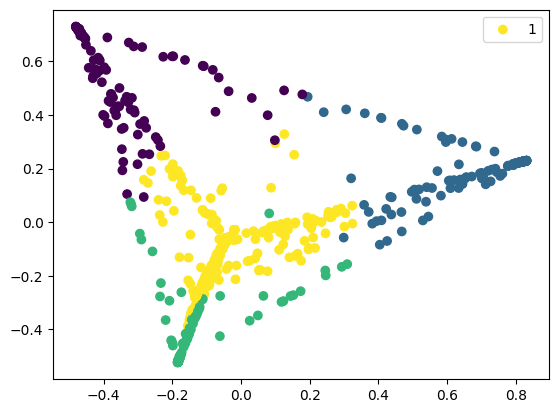

In [21]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

pca = PCA(n_components=2)
clusters = pca.fit_transform(topic_matrix)
print(clusters)

fig, ax = plt.subplots()

ax.scatter(clusters[:, 0], clusters[:, 1], c = best[2].labels_)
ax.legend(clustering_model.labels_)

Let's take one of the clusters and the topic, and see if they are related

In [ ]:
for i, label in enumerate(clustering_model.labels_):
    if label == 